In [8]:
from google.cloud import storage
import io
import warnings
warnings.filterwarnings("ignore") # Suppress all warnings
import pandas as pd
import json
import hashlib
from datetime import datetime
import logging
from pathlib import Path
import io
import concurrent.futures
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import infer_dtype

In [9]:
# Initialize Storage clients

storage_client = storage.Client()

print("Authentication successful!")

storage_client = storage.Client()

Authentication successful!


In [10]:
class DataQualityTester:
    def __init__(self, source_bucket: str, source_path: str, target_bucket: str, target_path: str, delimiter: str = '|'):
        self.source_bucket = source_bucket
        self.source_path = source_path
        self.target_bucket = target_bucket
        self.target_path = target_path
        self.delimiter = delimiter
        self.setup_logging()
        self.storage_client = storage.Client()
        self.accuracy_df = pd.DataFrame(columns=["source_records", "target_records", "completeness_percentage", "mismatches", "test_timestamp"])
        self.error_details_df = pd.DataFrame(columns=["row_index", "field", "source_value", "target_value", "error_type"])

    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            filename=f'data_quality_test_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
        )

    def read_gcs_file(self, bucket_name: str, file_path: str) -> io.StringIO:
        bucket = self.storage_client.bucket(bucket_name)
        blob = bucket.blob(file_path)
        content = blob.download_as_text()
        return io.StringIO(content)

    def read_source_file(self, chunk_size: int = 100000) -> pd.DataFrame:
        gcs_file = self.read_gcs_file(self.source_bucket, self.source_path)
        return pd.read_csv(gcs_file, delimiter=self.delimiter, chunksize=chunk_size)

    def read_target_json(self, chunk_size: int = 100000) -> Dict:
        gcs_file = self.read_gcs_file(self.target_bucket, self.target_path)
        records = []
        for line in gcs_file:
            records.append(json.loads(line))
            if len(records) >= chunk_size:
                yield records
                records = []
        if records:
            yield records

    def compare_batch(self, source_chunk: pd.DataFrame, target_chunk: List[Dict]) -> Tuple[int, int, List[str]]:
        mismatches = []
        target_df = pd.DataFrame(target_chunk)
        target_df.columns = [col.lower() for col in target_df.columns]
        source_chunk.columns = [col.lower() for col in source_chunk.columns]
        source_count = len(source_chunk)
        target_count = len(target_df)
        common_columns = list(set(source_chunk.columns) & set(target_df.columns))
        for col in common_columns:
            for idx, (src_val, tgt_val) in enumerate(zip(source_chunk[col].astype(str), target_df[col].astype(str))):
                if src_val != tgt_val:
                    mismatches.append(f"Column {col} has mismatched values.")
                    self.error_details_df = pd.concat([
                        self.error_details_df, 
                        pd.DataFrame([{"row_index": idx, "field": col, "source_value": src_val, "target_value": tgt_val, "error_type": "Mismatch" }])
                    ], ignore_index=True)
        return source_count, target_count, mismatches

    def run_quality_test(self) -> Dict:
        total_source_records, total_target_records, all_mismatches = 0, 0, []
        logging.info(f"Starting data quality test for {self.source_path} -> {self.target_path}")
        source_chunks, target_chunks = self.read_source_file(), self.read_target_json()
        with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
            futures = [executor.submit(self.compare_batch, src, tgt) for src, tgt in zip(source_chunks, target_chunks)]
            for future in concurrent.futures.as_completed(futures):
                src_count, tgt_count, mismatches = future.result()
                total_source_records += src_count
                total_target_records += tgt_count
                all_mismatches.extend(mismatches)
        completeness_percentage = (total_target_records / total_source_records * 100) if total_source_records > 0 else 0
        results = {"source_records": total_source_records, "target_records": total_target_records, "completeness_percentage": completeness_percentage, "mismatches": all_mismatches, "test_timestamp": datetime.now().isoformat()}
        logging.info(f"Test completed. Results: {json.dumps(results, indent=2)}")
        self.accuracy_df = pd.concat([self.accuracy_df, pd.DataFrame([results])], ignore_index=True)
        self.save_reports_to_csv()
        return results
    
    def save_reports_to_csv(self):
        # Save detailed mismatches to a CSV file
        if not self.error_details_df.empty:
            error_csv_filename = "detailed_mismatches.csv"
            self.error_details_df.to_csv(error_csv_filename, index=False)
            logging.info(f"Detailed mismatches saved to: {error_csv_filename}")
        else:
            logging.info("No mismatches found; skipping detailed mismatches CSV creation.")

        # Save summary results to a CSV file
        summary_csv_filename = "data_quality_summary.csv"
        self.accuracy_df.to_csv(summary_csv_filename, index=False)
        logging.info(f"Summary results saved to: {summary_csv_filename}")


if __name__ == "__main__":
    tester = DataQualityTester(
        source_bucket="samplebucketvrs",
        source_path="Data_Validation/large_source_data.txt",
        target_bucket="samplebucketvrs",
        target_path="Data_Validation/large_target_data.json",
        delimiter="|"
    )
    results = tester.run_quality_test()
    result_df = pd.DataFrame([results])
    result_df.dropna(axis=1, how='all', inplace=True)
    accuracy_df = pd.concat(
        [tester.accuracy_df.dropna(axis=1, how='all'), pd.DataFrame([results]).dropna(axis=1, how='all')], 
        ignore_index=True
    )
    #accuracy_df.head()
    #results = tester.run_quality_test()
    print("Summary Results and Detailed Mismatches saved in Excel and CSV formats.")

    print(tester.error_details_df.head())
#print(result_df)

Summary Results and Detailed Mismatches saved in Excel and CSV formats.
  row_index           field source_value target_value error_type
0      5535  loyalty_points          462          431   Mismatch
1      6770  loyalty_points          524          563   Mismatch
2     30850  loyalty_points          356          406   Mismatch
3     32392  loyalty_points          410          422   Mismatch
4     38510  loyalty_points          512          557   Mismatch


<AxesSubplot:title={'center':'Mismatch Frequencies by Column'}>

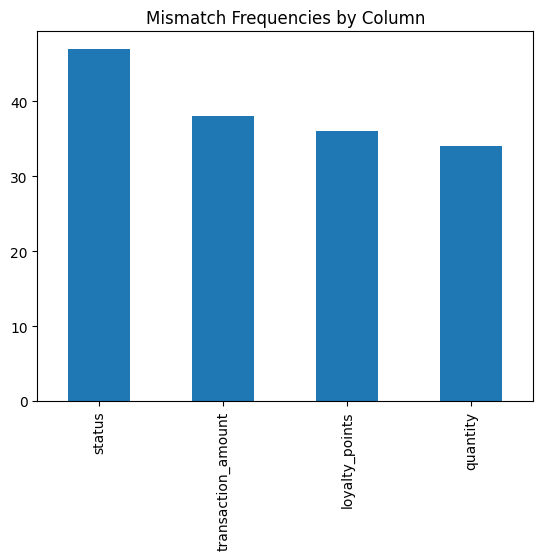

In [11]:
mismatch_summary = tester.error_details_df['field'].value_counts()
mismatch_summary.plot(kind='bar', title='Mismatch Frequencies by Column')

               Column  Mismatch_Count  Mismatch_Percentage
0              status              47               0.0094
1  transaction_amount              38               0.0076
2      loyalty_points              36               0.0072
3            quantity              34               0.0068


<AxesSubplot:title={'center':'Corrected Mismatch Percentage by Column'}, xlabel='Column'>

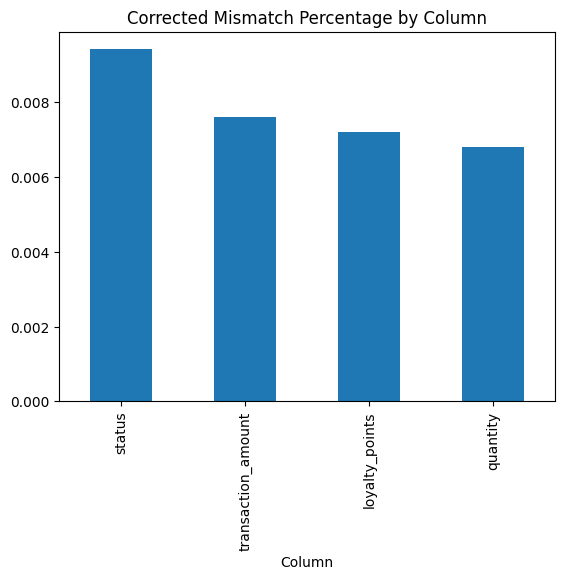

In [12]:
# Ensure total_source_rows is correct
total_source_rows = tester.accuracy_df['source_records'].sum()

# Count mismatches per column
mismatch_counts = tester.error_details_df['field'].value_counts()

# Calculate mismatch percentage per column
mismatch_percentages = (mismatch_counts / total_source_rows) * 100

# Create a summary DataFrame
mismatch_summary = pd.DataFrame({
    "Column": mismatch_counts.index,
    "Mismatch_Count": mismatch_counts.values,
    "Mismatch_Percentage": mismatch_percentages.values
})

# Display the corrected summary
print(mismatch_summary)

# Optional: Plot mismatch percentages
mismatch_summary.plot(
    x='Column', y='Mismatch_Percentage', kind='bar', title='Corrected Mismatch Percentage by Column', legend=False
)
